# Example emulation of PROSAIL using ``gp_emulator``

## J  Gomez-Dans (NCEO & UCL)

The purpose of this notebook is to demonstrate the emulation (and part validation) of the PROSAIL model using the simple GP library produced by UCL. We use the PROSAIL model for convenience: it's fast even on a laptop. A similar approach can be taken with other models of course. You can install the ``gp_emulator`` library directly from the internet using ``pip``. Just execute the next code cell.

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
%matplotlib inline
import sys
import scipy.stats


sys.path.append ( "..")

First, we need to create a training set. To do this, we will just define the bounds of the parameters of PROSAIL. In this case, I'm using the transformations from Weiss et al (check!) that quasi-linarise typical optical RT models. These are however not required you can also emulate on "true units" if you wanted!

[('N', 2.5), ('Cab', 5.1293294387550574), ('Car', 5.1293294387550574), ('Brown', 1.0), ('Cw', 0.0010258658877510115), ('Cm', 0.00051293294387550576)]
[('N', 1.6499999999999999), ('Cab', 69.314718055994533), ('Car', 69.314718055994533), ('Brown', 0.5), ('Cw', 0.013862943611198907), ('Cm', 0.0069314718055994533)]
[('N', 0.80000000000000004), ('Cab', 299.57322735539907), ('Car', 299.57322735539907), ('Brown', 0.0), ('Cw', 0.059914645471079817), ('Cm', 0.029957322735539908)]
{'Brown': 0.5, 'Cm': 0.0069314718055994533, 'Car': 69.314718055994533, 'N': 1.6499999999999999, 'Cab': 69.314718055994533, 'Cw': 0.013862943611198907}


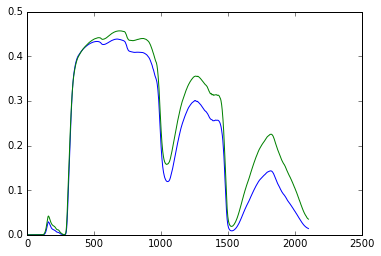

In [16]:
import numpy as np
import pylab as plt
import leaf
%matplotlib inline
import json
from scipy.stats import linregress
import sys
sys.path.append ( "..")
import gp_emulator

#print gp_emulator.__file__
parameters = [i.title() for i in [ 'n', 'cab', 'car', 'brown', 'cw', 'cm']]

# these are in internal state space (i.e. normalised)
min_vals = [ 0.8       ,  0.05,  0.05,  0. ,  0.05, 0.05]
max_vals = [ 2.5       ,  0.95  ,  0.95  ,  1 ,  0.95,0.95]


mean_vals = list(0.5*(np.array(min_vals)+max_vals))

def inverse_transform ( x ):
    """Inverse transform the PROSAIL parameters"""
    x_out = np.array(x)*1.
    # Cab, posn 1
    x_out[1] = -100.*np.log ( x[1] )
    # Car, posn 2
    x_out[2] = -100.*np.log ( x[2] )
    # Cw, posn 4
    x_out[4] = (-1./50.)*np.log ( x[4] )
    #Cm, posn 5
    x_out[5] = (-1./100.)*np.log ( x[5] )
    return list(x_out)


mean_vals_real = inverse_transform(mean_vals)
print zip(parameters,inverse_transform(max_vals))
print zip(parameters,mean_vals_real)
print zip(parameters,inverse_transform(min_vals))
driver = dict(zip(parameters,mean_vals_real))



driver2 = driver.copy()
for k in driver.keys():
    driver2[k] = 1000.
driver2['N'] = driver['N']
l = leaf.Leaf()
l.rt(driver2)
surf = l.r
#plt.figure()
##plt.plot(l.r)
#plt.plot(l.t)
#print driver2

l = leaf.Leaf()
l.rt(driver)
plt.figure()
plt.plot(l.r-surf)
plt.plot(l.t)
print driver



In [18]:
def leaf_rt_model ( x, passband=None, do_trans=True ):
    """A coupled land surface/atmospheric model, predicting refl from
    land surface parameters. Thisfunction provides estimates of refl for 
    a particular illumination geometry.
    
    The underlying land surface reflectance spectra is simulated using
    PROSPECT. The input parameter ``x[0]`` is a vector with the following components:
        
        * ``n``
        * ``cab``
        * ``car``
        * ``brown``
        * ``cw``
        * ``cm``

    """
    x_real = inverse_transform(x[0])
    driver = dict(zip(parameters,x_real))
    driver2 = dict(zip(parameters,x_real*0+1000))
    driver2['N'] = driver['N']
    l.rt(driver2)
    surf = l.r
    #omega = l.r + l.t
    #zeta = l.t/omega
    #print omega.shape
    return np.append(l.r-surf,l.t,surf)


In [19]:
n_train = 150
n_validate = 150
print gp_emulator.__file__
# initiate leaf
l = leaf.Leaf()
scale =  np.array([ 10000.  ,  10000.  ,  10000.  ,  10000. ,  10000 ,10000])

gp1 = gp_emulator.create_emulator_validation ( leaf_rt_model, list(parameters), list(min_vals), list(max_vals), 
                                n_train, n_validate, do_gradient=True, thresh=0.98,
                                n_tries=15 , common_hyp=False, scale=scale)

/Users/plewis/anaconda/lib/python2.7/site-packages/gp_emulator/__init__.pyc


TypeError: create_emulator_validation() got an unexpected keyword argument 'common_hyp'

0 LinregressResult(slope=0.9188127006451553, intercept=-0.017437963596181612, rvalue=0.99330414617463914, pvalue=0.0, stderr=0.0016489590229008145)
1 LinregressResult(slope=1.0373105316441409, intercept=-0.002207235424031959, rvalue=0.9689036756302406, pvalue=0.0, stderr=0.0040876179948833224)
2 LinregressResult(slope=0.65588666297061682, intercept=0.0071785650969327054, rvalue=0.60109886358947684, pvalue=0.0, stderr=0.013455503675191056)
3 LinregressResult(slope=0.65173095810833803, intercept=0.0031340991365957872, rvalue=0.87713865731024065, pvalue=0.0, stderr=0.0055059372756781693)
4 LinregressResult(slope=1.0422873487473479, intercept=-0.015039667076956129, rvalue=0.97654790139724312, pvalue=0.0, stderr=0.0035457964246752159)
5 LinregressResult(slope=2.137697540688432, intercept=-0.0025090013161364055, rvalue=0.96583921236190873, pvalue=0.0, stderr=0.0088502331841774935)
0 [  0.13355373   0.36891403   0.13083742   0.08874732   1.09941743
   0.59038726  21.00020358   1.73421158]
1 [

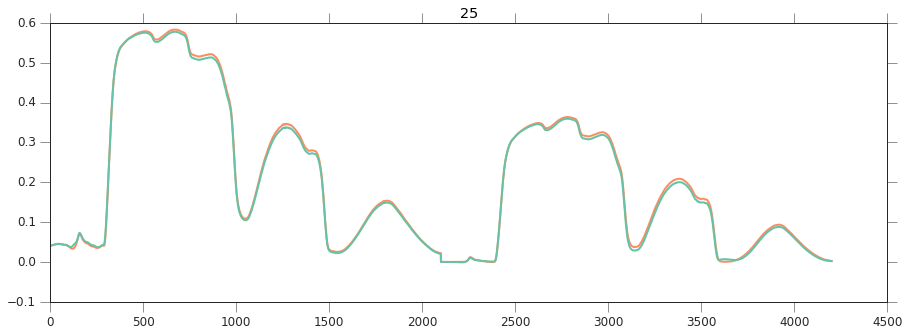

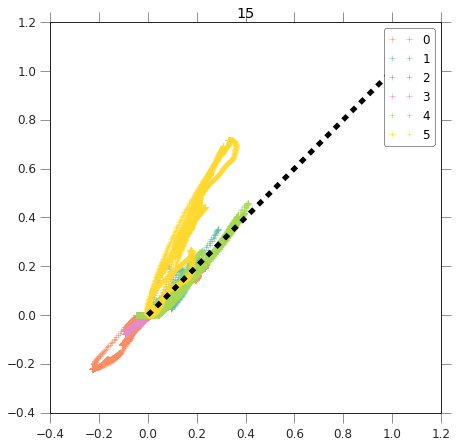

In [13]:

nt = 100

ggp , validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = gp1
plt.figure(figsize=(15,5))
for i in [np.random.randint(nt)]:
    plt.title('%d'%i)
    plt.plot(validate_output[i])
    plt.plot(emulated_validation[i])

plt.figure(figsize=(7,7))
for i in [np.random.randint(nt)]:
    plt.title('%d'%i)
    for j in xrange(emulated_gradient[i].shape[0]):
        plt.plot(emulated_gradient[i][j],validate_gradient[i][j],'+',label=str(j))
        print j,scipy.stats.linregress(emulated_gradient[i][j].flatten(),validate_gradient[i][j].flatten())
    plt.plot([0,1.],[0.,1.],'k--',lw=5)
plt.legend()
for i in xrange(len(ggp.emulators)):
    print i,np.exp(ggp.emulators[i].theta)

In [14]:
n_train = 150
n_validate = 150

# initiate leaf
l = leaf.Leaf()

gp = gp_emulator.create_emulator_validation ( leaf_rt_model, list(parameters), list(min_vals), list(max_vals), 
                                n_train, n_validate, do_gradient=True, thresh=0.98, verbose=True,
                                n_tries=5 , common_hyp=True, scale=scale)

> /Users/plewis/anaconda/lib/python2.7/site-packages/gp_emulator/emulation_helpers.py(150)create_emulator_validation()
-> if verbose:
(Pdb) c
trying Multivariate Emulator ... Decomposing the input dataset into basis functions... Done!
 ====> Using 13 basis functions
After 5, the minimum cost was 2.111013e+03
... done
common_hyp


0 LinregressResult(slope=0.99924950379550048, intercept=-0.0088127240106138337, rvalue=0.97718411307512754, pvalue=0.0, stderr=0.0033513140897754295)
1 LinregressResult(slope=1.2868953603764433, intercept=-0.025397210379709947, rvalue=0.73990789266908974, pvalue=0.0, stderr=0.018053759206882028)
2 LinregressResult(slope=0.078439196867618216, intercept=0.0011098762225903573, rvalue=0.32055924149720927, pvalue=4.9362983531585601e-101, stderr=0.0035764728593500276)
3 LinregressResult(slope=0.95357837245884691, intercept=0.0070943171502347571, rvalue=0.80957610640907929, pvalue=0.0, stderr=0.010668987648645782)
4 LinregressResult(slope=0.98279384591465124, intercept=0.048741346452563422, rvalue=0.71600062389049679, pvalue=0.0, stderr=0.014785696797604593)
5 LinregressResult(slope=0.26433110637588819, intercept=0.025462546172654536, rvalue=0.21650319150253569, pvalue=9.3060570133781348e-46, stderr=0.018392237569272319)
0 [  3.99969280e-01   7.00429444e-01   1.37905510e+00   1.74888795e-01
 

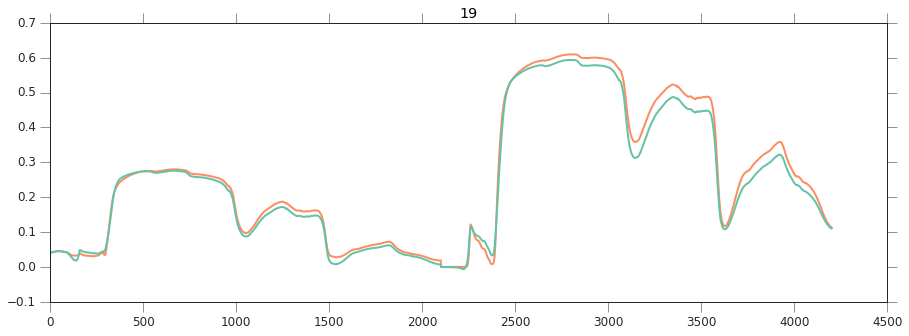

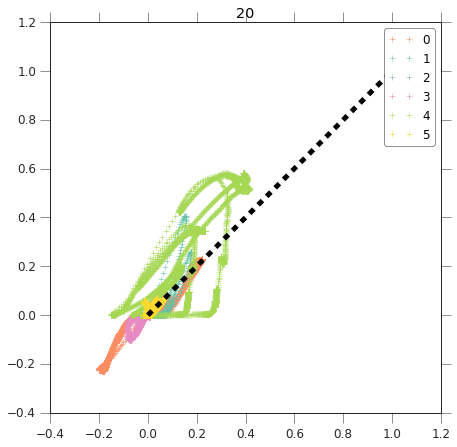

In [15]:
import scipy.stats

ggp , validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = gp
plt.figure(figsize=(15,5))
for i in [np.random.randint(nt)]:
    plt.title('%d'%i)
    plt.plot(validate_output[i])
    plt.plot(emulated_validation[i])

plt.figure(figsize=(7,7))
for i in [np.random.randint(nt)]:
    plt.title('%d'%i)
    for j in xrange(emulated_gradient[i].shape[0]):
        plt.plot(emulated_gradient[i][j],validate_gradient[i][j],'+',label=str(j))
        print j,scipy.stats.linregress(emulated_gradient[i][j].flatten(),validate_gradient[i][j].flatten())
    plt.plot([0,1.],[0.,1.],'k--',lw=5)
plt.legend()
for i in xrange(len(ggp.emulators)):
    print i,np.exp(ggp.emulators[i].theta)

basis functions (13, 4202)


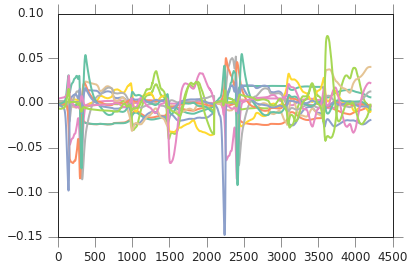

In [16]:
print 'basis functions',ggp.basis_functions.shape
plt.plot(ggp.basis_functions.T)

In [17]:
try:
    ggp.dump_emulator('leaf_emulator','leaf',0,0,0)
except:
    pass

Having set up the emulators, now lets check we can do the required calculations by hand:

[1.6499999999999999, 0.5, 0.5, 0.5, 0.5, 0.5]
(6, 4202) 13
= -19.8899166054
= -0.680128265831
= 0.395810898387
= 0.553390908956
= 0.500814958731
= 0.126094207854
= -0.00105269748402
= -0.194370848796
= 0.00339993773561
= -0.00784575667104
= 0.0181046946638
= 0.010899183522
= 0.00450614346779


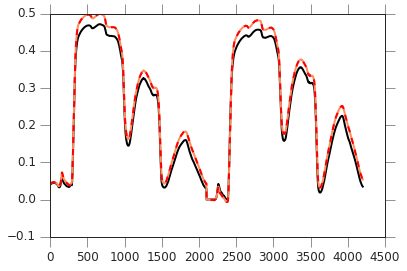

In [22]:
import scipy.spatial.distance as dist

print mean_vals
mean_vals_real = inverse_transform(mean_vals)
l.rt(dict(zip(parameters,mean_vals_real)))
plt.plot(np.append(l.r,l.t),'k')
plt.plot(ggp.predict([mean_vals])[0])

# for pc0 we have mu = a . b
# hyperparams: array ( N_params + 2, N_PCs )

xx = 0
xd = np.zeros((6,ggp.basis_functions.shape[1]))
xdtest = np.zeros_like(xd)

print xd.shape,ggp.basis_functions.shape[0]

# loop over basis functions
for i in xrange(ggp.basis_functions.shape[0]):
    em = ggp.emulators[i]
    expX = np.exp ( em.theta )
    
    pred_mu, pred_var, grad = em.predict ( np.atleast_2d(mean_vals) )
    # a is the exp -ve distance function for output locations
    s = np.array(expX[:6])
    #s = 1
    # squared euclidean distance normalised by s
    d = (ggp.emulators[i].inputs - mean_vals)
    a = (d*d*s).sum(axis=1)
    
    # not clear if 7 is used here???
    #a = expX[7] + expX[6]*np.exp(-0.5*a)
    a = expX[6]*np.exp(-0.5*a)
    
    c = a*d.T
    pred_mu = np.dot( a.T, em.invQt)
    # differential
    pred_grad = np.atleast_2d(expX[:em.D] * np.dot(c, em.invQt))
    print '=',pred_mu
    #a = expX[i]*np.exp(-0.5*a)
    #a = pred_mu
    xx += pred_mu * ggp.basis_functions[i]
    xd += grad.T*ggp.basis_functions[i]
    xdtest += pred_grad.T*ggp.basis_functions[i]


plt.plot(xx,'r--')

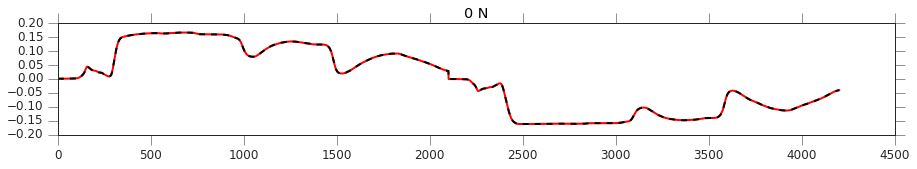

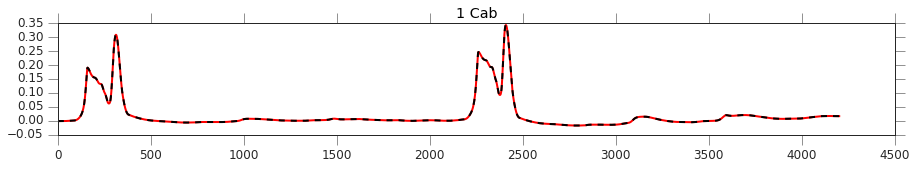

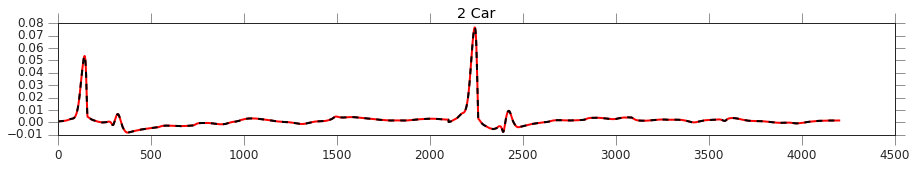

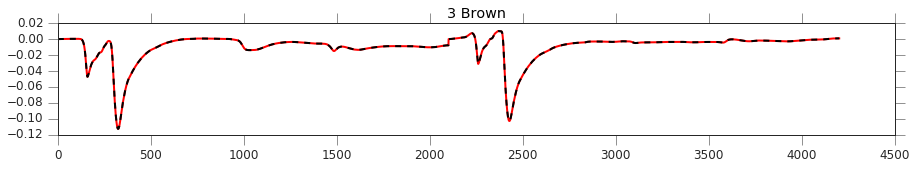

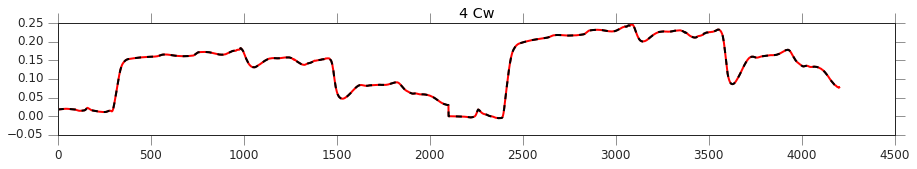

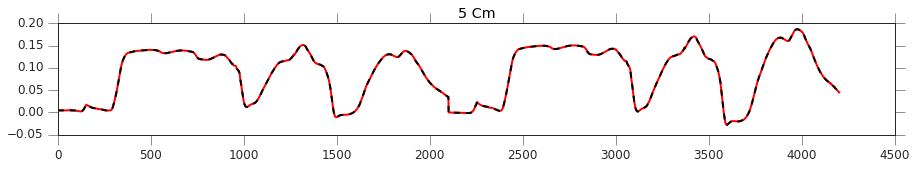

In [19]:
# gradients at mean values
for i in xrange(6):
    plt.figure(figsize=(15,2))
    plt.title('%d %s'%(i,parameters[i]))
    plt.plot(xd[i],'r')
    plt.plot(xdtest[i],'k--')

In [ ]:
print 'The input locations are all the same'
print '=',ggp.emulators[0].inputs
print '=',ggp.emulators[1].inputs
norm = (ggp.emulators[0].inputs - lim.T[0])/(r)
print 'normalised',norm
p = 1
quant = (np.round(norm,1)*10**1).astype(int)
print quant
# how to use DCT --- per axis!!!


In [ ]:
grid = np.ogrid[(slice(0,1.001,0.02),)*6]

In [ ]:
lim = np.array(zip(min_vals,max_vals))
print lim.shape
dlim = lim.T[1]-lim.T[0]
i = 0
grid[i] * dlim[i] + lim[i][0]

(grid * dlim)[i] + lim[i][0]

We have now created 200 samples of our 10-element *state vector*. We need to import PROSAIL and make it run for a **particular illumination/acquisition geometry** with the parameters. We can install the PROSAIL bindings for Python easily. Also, note that PROSAIL requires parameters in true units, so we need to have a function to do the inverse transformation handy, in this case ``inverse_transform``. ``do_fwd_model`` is in charge of running the RT model and returning the spectra (note that in some cases you might get ``NaN`` and ``Inf``, so best to check for inconsistencies!)

In the previous cell, ``rt_model`` is the *simulator* function. We will need to run this function a number of times, with carefully selected parameters, to provide the emulator with a training set, so that the emulator hyperparameters can be estimated. We will also run ``rt_model`` to obtain additional model output for input parameters that have not gone into the emulator and that will serve as a test of the emulator. the ``gp_emulator`` library has a helper function to deal with this, called ``create_emulator_validation``. In addition to doing all this, it also produces an evaluation dataset of the gradient of the simulator, which can be used to test the GP approximation to the gradient.

Let's explore the emulators first emulating PROSAIL for the 7 different MODIS bands, which we'll assume are characterised by a top hat passband function.

We will assume an illumination/viewing geometry of sza=30, vza and raa 0. For each band, we will use 300 training samples, and validate on 1000 independent samples. Note that this function will make use of the simulator by running it in parallel if you have several cores available.

Note that this code is fairly inefficient, as inside ``rt_model`` we're doing full spectrum calculations, that in this case get repeated nine times. But time is on my side here...

In [ ]:
from functools import partial
b_min = np.array( [ 620., 841, 459, 545, 1230, 1628, 2105] )
b_max = np.array( [ 670., 876, 479, 565, 1250, 1652, 2155] )
wv = np.arange ( 400, 2501 )
passband = []

n_train = 300
n_validate = 1000

# initiate leaf
l = leaf.Leaf()

retval = []
for iband,bmin in enumerate ( b_min ):
    print "Doing band %d" % (iband+1)
    passband = np.nonzero( np.logical_and ( wv >= bmin, wv <= b_max[iband] ) )
    simulator = partial ( rt_model, passband=passband )
    x = gp_emulator.create_emulator_validation ( simulator, parameters, min_vals, max_vals, 
                                n_train, n_validate, do_gradient=True, 
                                n_tries=15, args=(l,) )
    retval.append ( x )


In [ ]:
fig1, axs1 = plt.subplots ( nrows=5, ncols=2, figsize=(12,12))
#fig2, axs2 = plt.subplots ( nrows=4, ncols=3, figsize=(9,9))
axs1 = axs1.flatten()
#axs2 = axs2.flatten()
ignores = []
for iband in [0,5]:
    gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = retval[iband]

    for i in xrange ( 10):
        if len( np.unique(validate_gradient[:,i]) ) < 5:
            ignores.append ( i)
            continue
        x, y = validate_gradient[:, i], emulated_gradient[:, i]
        if iband == 0:
            axs1[i].plot ( x,y, 'x', mec="#FC8D62", mfc="none")
        elif iband == 5:
            axs1[i].plot ( x, y, '+', mec="#66C2A5", mfc="none")
        ymax = max ( x.max(), y.max() )*1.2
        ymin = min ( x.min(), y.min() )*1.2
        axs1[i].set_xlim ( ymin, ymax)
        axs1[i].set_ylim ( ymin, ymax)
        axs1[i].plot( [ymin, ymax], [ymin, ymax], 'k--', lw=0.5 )
        axs1[i].set_title ( "%s (band %d)" % ( parameters[i], iband+1))
        pretty_axes ( axs1[i])
plt.tight_layout()
for i in ignores:
    axs1[i].set_visible ( False )


In [ ]:
fig1, axs1 = plt.subplots ( nrows=5, ncols=2, figsize=(12,12))
#fig2, axs2 = plt.subplots ( nrows=4, ncols=3, figsize=(9,9))
axs1 = axs1.flatten()
#axs2 = axs2.flatten()
ignores = []
for iband in [2]:
    gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = retval[iband]

    for i in xrange ( 10):
        if len( np.unique(validate_gradient[:,i]) ) < 5:
            ignores.append ( i)
            continue
        x, y = validate_gradient[:, i], emulated_gradient[:, i]

        axs1[i].plot ( x, y, 'o', mec="#66C2A5", mfc="none")
        ymax = max ( x.max(), y.max() )*1.2
        ymin = min ( x.min(), y.min() )*1.2
        axs1[i].set_xlim ( ymin, ymax)
        axs1[i].set_ylim ( ymin, ymax)
        axs1[i].plot( [ymin, ymax], [ymin, ymax], 'k--', lw=0.5 )
        axs1[i].set_title ( "%s (band %d)" % ( parameters[i], iband+1))
        pretty_axes ( axs1[i])
plt.tight_layout()
for i in ignores:
    axs1[i].set_visible ( False )


## Emulating SEMIDISCRETE

We can also try emulating SEMIDISCRETE. This is pretty straightforward, and basically just needs a different ``rt_model`` function that calls the Python SEMIDISCRETE bindings...

In [ ]:
f = np.load("semidiscrete_300.npz")
semi_refl = f['returns']
semi_input = f['samples']


In [ ]:
params_semi = [ 'n', 'cab', 'car', 'cbrown', 'cw', 'cm', 'lai', 'price1', 'price2']
min_vals_semi = [ 0.8       ,  0.46301307,  0.95122942,  0.        ,  0.02829699,
            0.03651617,  0.04978707,  -0.5, -0.5]
max_vals_semi = [ 2.5       ,  0.998002  ,  1.        ,  1.        ,  0.80654144,
            0.84366482,  0.99501248,  1, 1     ]


In [ ]:
print semi_input.shape
print semi_refl.shape
retval = []
for iband,bmin in enumerate ( b_min ):
    print "Doing band %d" % (iband+1)
    
    gp = gp_emulator.GaussianProcess (  semi_input, semi_refl[ :, iband] )
    gp.learn_hyperparameters(n_tries=10)
    retval.append ( gp )


In [ ]:
new_semi_gp = retval
f=np.load("semidiscrete_030_000_000_000_MODIS_VALIDATION_new.npz")
validate=f['validate']
vali_refl=f['refl_boa']
print validate.shape, vali_refl.shape

In [ ]:
fig1, axs1 = plt.subplots ( nrows=2, ncols=4, figsize=(14,7))

axs1 = axs1.flatten()
#val_set = []

for iband in xrange ( 7):
    validate_output = vali_refl[:,iband]
    #emulated_validation = f['emu_boa'][:,iband]#retval[iband].predict ( validate)[0]
    emulated_validation = retval[iband].predict ( validate )[0]
    slope, intercept, r_value, p_value, std_err = linregress( validate_output, emulated_validation.squeeze() )
    axs1[iband].plot ( validate_output, emulated_validation, 'o', mec="#FC8D62", mfc="none", rasterized=True )
    ymax = np.max ( validate_output.max(), emulated_validation.max() )
    if iband == 2:
        ymax = ymax*1.3
    axs1[iband].plot ( [0, 1.2*ymax], [0, 1.2*ymax], 'k--', lw=0.5)
    p = np.polyfit ( validate_output, emulated_validation, 1)
    mae = np.abs(validate_output- emulated_validation.squeeze()).max()
    print "%d & %6.3f & %6.3e & %6.4f & %6.3e & %6.3e\\\\" % (iband+1, slope, intercept, r_value, std_err, mae),
    x = np.linspace(0, 1.2*ymax, 5)
    axs1[iband].plot ( x, np.polyval ( p, x), '-', lw=0.4  )
    axs1[iband].set_ylim ( 0, ymax )
    axs1[iband].set_xlim ( 0, ymax )
    pretty_axes ( axs1[iband])
    axs1[iband].set_title ( "MODIS Band %d" % (iband+1))
    print
axs1[4].set_ylabel ( "Emulated reflectance [-]")
axs1[4].set_xlabel ( "SEMIDISCRETE reflectance [-]")
plt.tight_layout()     
axs1[7].set_visible (False)
#axs1[8].set_visible (False)


fig1.savefig("semidiscrete_emulator_300.pdf", dpi=600, rasterize=True, bbox_inches="tight" )
fig1.savefig("semidiscrete_emulator_300.png", dpi=600, rasterize=True, bbox_inches="tight" )

## Spectral emulation

Perhaps monsieur would like a full spectrum emulation? We can easily do that by not subsetting the ``rt_model`` function, and letting ``gp_emulator`` create the emulator and validation set for you....

In [ ]:
n_train = 300
n_validate = 1000
x = gp_emulator.create_emulator_validation ( rt_model, parameters, min_vals, max_vals, 
                                n_train, n_validate, do_gradient=True, 
                                n_tries=10, args=(30, 0, 0) )

So we now have an emulator for the model. Let's look at the residuals distribution with respect to wavelength, plotting the mean residual, and the 5-95% as well as the 25-75% posterior ranges:

In [ ]:
residual = x[2] - x[4]
wv = np.arange ( 400, 2501 )
plt.plot ( wv, residual.mean(axis=0))
plt.fill_between( wv, np.percentile( residual, 5, axis=0 ), 
                 np.percentile( residual, 95, axis=0 ), color="0.8")
plt.fill_between( wv, np.percentile( residual, 25, axis=0 ), 
                 np.percentile( residual, 75, axis=0 ), color="0.5")
plt.xlim(400,2500)
plt.ylim ( -0.012, 0.012)

pretty_axes(plt.gca())
plt.yticks([-0.01, -0.005, 0, 0.005, 0.01])


We see this as being a pretty good result, but with nevertheless still has some outliers in the light grey area. We ought to consider that the typical "noise" in the observations is of the order of 0.01 or thereabouts, so the emulation error is pretty low. Let's now test the gradient for e.g. Cab on the red region (650 nm) and LAI on the near infrared (865nm):

In [ ]:
passer = np.abs( x[3][:,1,250]-x[5][:,1,250] ) < 0.03
plt.plot ( x[3][passer,1,250],  x[5][passer, 1,250], 'v', rasterized=True, mec="none", ms=6, 
          label=r'$\left.\frac{\partial H}{\partial C_{ab}}\right|_{\lambda=650\,nm}$')

passer = np.abs( x[3][:,6,250]-x[5][:,6,250] ) < 0.01
plt.plot ( x[3][passer,6,465],  x[5][passer,6,465], '^',  rasterized=True, mec="none", ms=6,
          label=r'$\left.\frac{\partial H}{\partial LAI}\right|_{\lambda=850\,nm}$')
plt.xlim ( -1.5, 1.5)
plt.ylim ( -1.5, 1.5)
plt.plot([-1.5, 1.5], [-1.5, 1.5], '--' )
plt.xlabel ( "Finite differences gradient (PROSAIL)")
plt.ylabel("Emulated gradient")
plt.legend(loc='best', numpoints=1, fontsize=16, markerscale=3, frameon=False )
pretty_axes(plt.gca())
plt.savefig("spectral_gradient_prosail.pdf", dpi=600, bbox_inches="tight", rasterize=True )
plt.savefig("spectral_gradient_prosail.png", dpi=600, bbox_inches="tight", rasterize=True )


Again, we see that the values are quite good except in the boundaries.

In [ ]:
plt.legend?